In [1]:
import warnings
warnings.simplefilter("ignore")

Make sure to run this notebook in a `CMSSW/src/` environment. It's also necessary to use `LCG_98` to have the correct version for `ROOT.RDataFrame` with the method `AsNumpy()`.

In [28]:
!source /cvmfs/cms.cern.ch/cmsset_default.sh
!source /cvmfs/sft.cern.ch/lcg/views/LCG_98/x86_64-centos7-gcc8-opt/setup.sh

In [54]:
%%capture
import os, glob
from json import loads as load_json
from json import dump as dump_json
import ipywidgets as widgets
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import mplhep as hep
import tensorflow as tf
import keras
import keras.backend as k
import keras.models
from keras.models import Sequential
from keras.layers.core import Dense, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.model_selection import train_test_split
import ROOT

plt.style.use(hep.style.CMS)

Before running this notebook, need to run the final DNN training script `final.py` from the [TTTT_TMVA_DNN](https://github.com/daniel-sunyou-li/TTTT_TMVA_DNN) Github repository. This notebook makes use of either the `.h5` or `.tf` model trained in that script, as well as the `data.json` file that is produced containing information for the ROC curve. In total, only two files need to be copied to the `dataset` directory located at the same level as the working directory to run this notebook. 

In [37]:
dirList = [ directory for directory in next( os.walk( os.getcwd() ) )[1] if "dataset" in directory.lower() ]
datasetDir = widgets.Dropdown( options = dirList )
datasetDir

Dropdown(options=('dataset',), value='dataset')

In [61]:
jsonNames = [ file for file in next( os.walk( os.path.join( os.getcwd(), datasetDir.value ) ) )[2] if ".json" in file ]
jsonName = widgets.Dropdown( options = jsonNames, value = "data.json" )
jsonName

Dropdown(index=1, options=('config_5j_1to50_S2B10.json', 'data.json'), value='data.json')

In [48]:
modelNames = [ file for file in next( os.walk( os.path.join( os.getcwd(), datasetDir.value ) ) )[2] if ".tf" in file or ".h5" in file ]
modelName = widgets.Dropdown( options = modelNames )
modelName

Dropdown(options=('final_model_5j_1to50_S2B10.tf',), value='final_model_5j_1to50_S2B10.tf')

In [65]:
%%capture
jsonFile = load_json( open( os.path.join( datasetDir.value, jsonName.value ) ).read() )
if modelName.value.endswith( ".tf" ):
    model = tf.keras.models.load_model( os.path.join( datasetDir.value, modelName.value ) )
elif modelName.value.endswith( ".h5" ):
    model = keras.models.load_model( os.path.join( datasetDir.value, modelName.value ) )

Edit the selections for both signal and background samples, will be applied using `RDataFrame`.

In [25]:
selection = {
    "SIGNAL": [
        "AK4HT > 500.",
        "MT_lepMet > 60.",
        "NJets_JetSubCalc >= 4",
        "corr_met_MultiLepCalc > 60."
    ],
    "BACKGROUND": [
        "AK4HT > 500.",
        "MT_lepMet > 60.",
        "NJets_JetSubCalc >= 4",
        "corr_met_MultiLepCalc > 60"
    ]
}

selection_string = { group: selection[ group ][0] for group in selection }

for group in selection: 
    for item in selection[ group ]:
        selection_string[ group ] += " && {}".format( item )

In [75]:
variables = jsonFile[ list( jsonFile.keys() )[0] ][ "parameters" ][ "variables" ]
print( ">> Found a list of {} variables".format( len( variables ) ) )

>> Found a list of 50 variables


__Important__: Edit these parameters based on user's information and where the `step2` samples are located. Important to specify the location for the samples.

In [29]:
eosUserName = "dali"
location = "BRUX"

sourceDir = {
    "LPC": "root://cmsxrootd.fnal.gov//store/user/{}/".format( eosUserName ),
    "BRUX": "root://brux30.hep.brown.edu:1094//isilon/hadoop/store/user/{}/".format( eosUserName )
}

sampleDir = "FWLJMET106XUL_1lep2017_3t_deepJetV1_step3/nominal/"

__Important__: Edit the samples you want to visualize. You can specify the ones to visualize later on.

In [30]:
samples = {
    "SIGNAL": [
        "TTTJ_TuneCP5_13TeV-madgraph-pythia8_hadd.root",
        "TTTW_TuneCP5_13TeV-madgraph-pythia8_hadd.root"
    ],
    "BACKGROUND": [
        "TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8_ttjj_hadd.root",
        "TTToHadronic_TuneCP5_13TeV-powheg-pythia8_ttjj_hadd.root",
        "TTToSemiLepton_HT500Njet9_TuneCP5_13TeV-powheg-pythia8_ttjj_hadd.root",
        "TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8_HT0Njet0_ttjj_1_hadd.root",
        "TTToSemiLeptonic_TuneCP5_13TeV-powheg-pythia8_HT500Njet9_ttjj_hadd.root"
    ]
}

In [159]:
nDF = {}
for sample in samples[ "SIGNAL" ]:
    rDF = ROOT.RDataFrame(
        "ljmet",
        os.path.join( sourceDir[ location ], sampleDir, sample )
    ).Filter( selection_string[ "SIGNAL" ] )
    nDF[ sample ] = rDF.AsNumpy( columns = variables )
    del rDF
for sample in samples[ "BACKGROUND" ]:
    rDF = ROOT.RDataFrame( 
        "ljmet", 
        os.path.join( sourceDir[ location ], sampleDir, sample )
    ).Filter( selection_string[ "BACKGROUND" ] )
    nDF[ sample ] = rDF.AsNumpy( columns = variables )
    del rDF

In [160]:
x, y = {}, {}
for sample in samples[ "SIGNAL" ] + samples[ "BACKGROUND" ]:
    x[sample] = np.array( [ y for x,y in nDF[ sample].items() ] ).transpose()
    y[sample] = model.predict( x[sample] )

Select the samples to view the discriminator shape for. Can choose multiple to group within signal or background.

In [155]:
plot_signal = widgets.SelectMultiple( options = samples["SIGNAL"], value = samples["SIGNAL"] )
plot_signal

SelectMultiple(index=(0, 1), options=('TTTJ_TuneCP5_13TeV-madgraph-pythia8_hadd.root', 'TTTW_TuneCP5_13TeV-mad…

In [156]:
plot_background = widgets.SelectMultiple( options = samples["BACKGROUND"], value = samples["BACKGROUND"] )
plot_background

SelectMultiple(index=(0, 1, 2, 3, 4), options=('TTTo2L2Nu_TuneCP5_13TeV-powheg-pythia8_ttjj_hadd.root', 'TTToH…

In [179]:
s_plot = np.concatenate( [ y[sample] for sample in y if sample in plot_signal.value ] )
b_plot = np.concatenate( [ y[sample] for sample in y if sample in plot_background.value ] )

Define plotting parameters here. 

In [181]:
plot_params = {
    "YEAR": "2017"
}

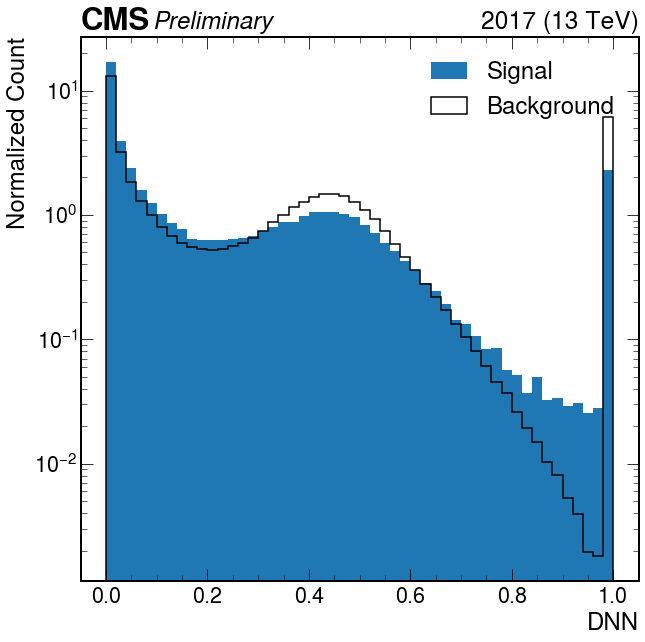

In [182]:
plt.style.use(hep.style.CMS)
plt.figure()
hep.cms.text( "Preliminary", fontsize = 24)
hep.cms.lumitext( "{} (13 TeV)".format( plot_params[ "YEAR" ] ) )
bins = np.linspace(0.,1.,51)
plt.hist(
    s_plot, bins = bins,
    label="Signal", density = True
)
plt.hist(
    b_plot, bins = bins,
    label="Background", density = True,
    histtype = "step", color = "black", linewidth = 1.5
)

plt.ylabel("Normalized Count", y = 1.0, ha = "right", fontsize = 24)
plt.yscale("log")
plt.xlabel("DNN", x = 1.0, ha = "right", fontsize = 24)
plt.legend(loc="best",fontsize=24)
plt.show()

Evaluate the training performance using the ROC curve and AUC score. Also visualize the ROC curve.

In [209]:
sig_hot = np.ones( len( s_plot ) )
bkg_hot = np.zeros( len( b_plot ) )

roc_points = roc_curve( 
    np.concatenate( ( sig_hot, bkg_hot ) ), 
    np.concatenate( ( s_plot[:,0], b_plot[:,0] ) )
)
auc_score = auc( roc_points[1], roc_points[0] )

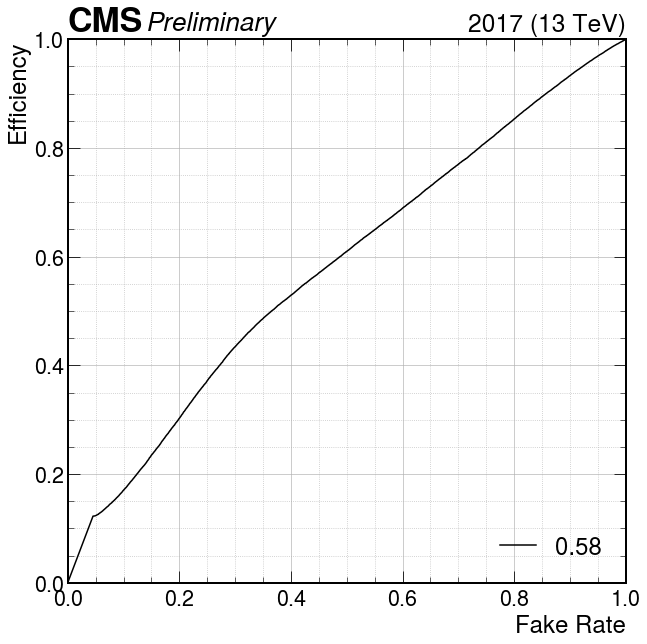

In [217]:
plt.figure()
hep.cms.text("Preliminary")
hep.cms.lumitext( "{} (13 TeV)".format( plot_params[ "YEAR" ] ) )

plt.plot(
    roc_points[1], roc_points[0],
    label = "{:.2f}".format( auc_score ),
    color = "k"
)

plt.xlabel("Fake Rate", x = 1.0, ha = "right", fontsize = 24)
plt.ylabel("Efficiency", y = 1.0, ha = "right",  fontsize = 24)
plt.ylim(0,1.0)
plt.xlim(0,1.0)
plt.grid(which="major",linestyle="-")
plt.grid(which="minor",linestyle=":")
plt.minorticks_on()
plt.legend(loc=4, fontsize = 24)
plt.show()